In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('owid-covid-data.csv')
df = df[(df.location == 'Russia') & (df.date >= '2020-03-02')].reset_index(drop=True)

In [3]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,RUS,Europe,Russia,2020-03-02,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
2,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
3,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
4,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [4]:
# заменим 0 занчения 'new_cases' на 1
df.replace({'new_cases': {0: 1.0}}, inplace=True)

In [5]:
# добавим столбец 'day_number'
df['day_number'] = df.index

features = df.drop(columns = ['total_cases', 'new_cases'])
targets = df[['total_cases', 'new_cases']]
# поделим данные на train/test
X_train, y_train = features.iloc[:50], targets.iloc[:50]
X_test, y_test = features.iloc[50:], targets.iloc[50:]

#### 2    
a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Во время обучения попадим на вход модели log(y) в качестве таргета. Далее полученное предсказание подставим в показатель exp. 

In [6]:
model = LinearRegression()
model.fit(X_train['day_number'].values.reshape(-1, 1), np.log(y_train))
preds = model.predict(X_test['day_number'].values.reshape(-1, 1))
preds_train = model.predict(X_train['day_number'].values.reshape(-1, 1))

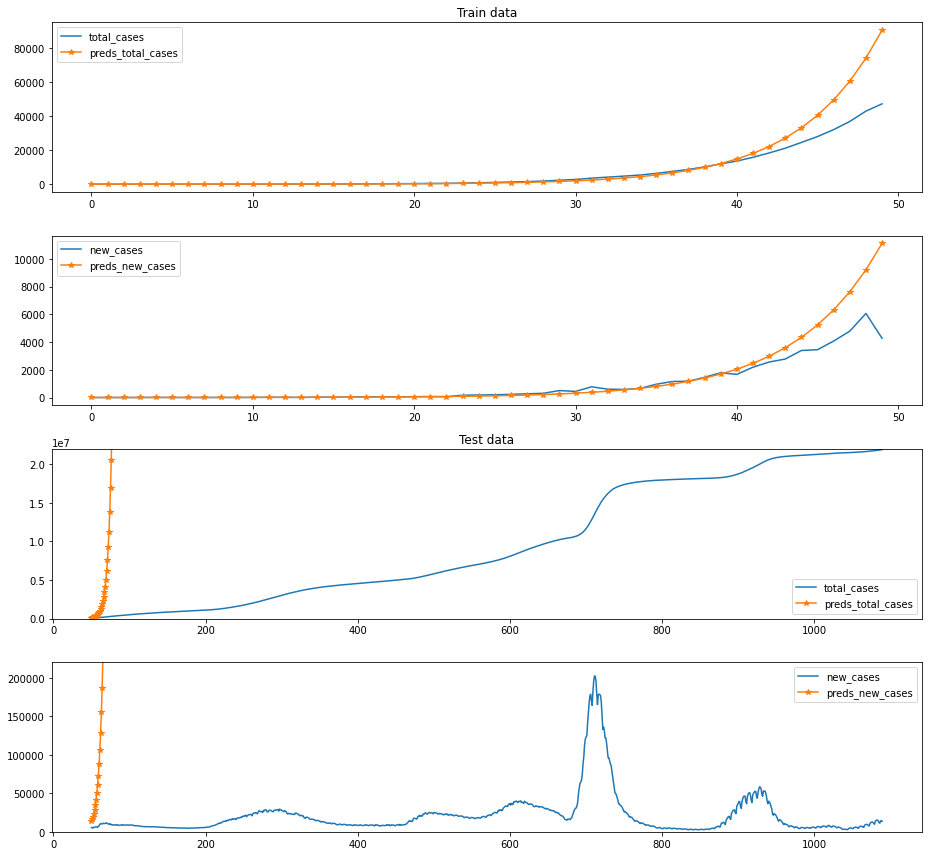

In [7]:
# Результаты обучения лин. регрессии
fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize=(13, 12))

axs[0].set_title('Train data')
axs[0].plot(X_train['day_number'], y_train.total_cases, label='total_cases')
axs[0].plot(X_train['day_number'], np.exp(preds_train[:, 0]), marker = '*', label='preds_total_cases')
axs[0].legend()

axs[1].plot(X_train['day_number'], y_train.new_cases, label='new_cases')
axs[1].plot(X_train['day_number'], np.exp(preds_train[:, 1]), marker = '*', label='preds_new_cases')
axs[1].legend()

axs[2].set_title('Test data')
axs[2].plot(X_test['day_number'], y_test.total_cases, label='total_cases')
axs[2].plot(X_test['day_number'], np.exp(preds[:, 0]), marker = '*', label='preds_total_cases')
axs[2].set_ylim([0, 2.2e7])
axs[2].legend()

axs[3].plot(X_test['day_number'], y_test.new_cases, label='new_cases')
axs[3].plot(X_test['day_number'], np.exp(preds[:, 1]), marker = '*', label='preds_new_cases')
axs[3].set_ylim([0, 220_000])
axs[3].legend()

fig.tight_layout()

Как видно из графиков выше, на тестовых данных модель с самого начала выдает очень большие значения, которые продолжают расти, т.к. exp монотонно возрастающая функция.

b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


In [26]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n


mu = np.array([0, 0])
sigma = 100 * np.array([[1, 0], [0, 1]])
# добавим столбец из 1
x_matrix = np.column_stack([np.ones(X_train.shape[0]), X_train["day_number"]])
y = np.log(y_train.total_cases)
# оценим дисперсию шума
sigma_noise = mean_squared_error(np.log(y_train.total_cases), preds_train[:, 0])

# апостериорное распределение параметров модели
cur_mu, cur_sigma = bayesian_update(mu, sigma, x_matrix, y, sigma_noise)
print(f'Мат.ожидание: {cur_mu}\nДисперсия: {cur_sigma}')

Мат.ожидание: [1.5552186  0.20114868]
Дисперсия: [[ 1.05941127e-03 -3.21033718e-05]
 [-3.21033718e-05  1.31034528e-06]]


c) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [31]:
def myplot_sample_lines(mu, sigma, x_matrix, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(X_train["day_number"].values, np.exp(x_matrix.dot(w)), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

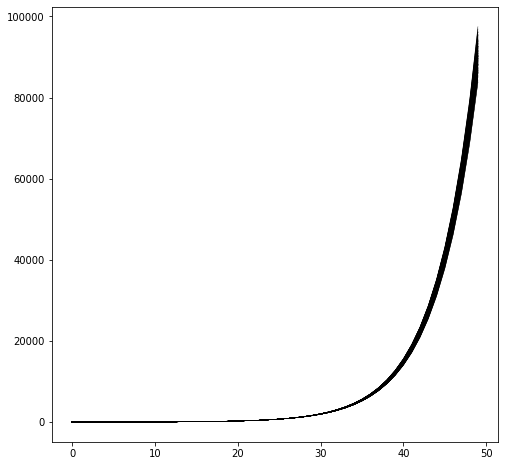

In [33]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_sample_lines(cur_mu, cur_sigma, x_matrix, 200)

In [53]:
# определим значения для случаев коронавируса в России в разные даты
day_index, real_value = [], []
data_list = ['2020-05-01', '2020-06-01', '2020-09-01']
for data_ls in list_data:
    tmp_df = df[df.date == data_ls]
    day_index.append(tmp_df.index[0])
    real_value.append(new_data_cov.total_cases.values[0])
    
predict_data = np.column_stack([np.ones(3), day_index])
# сгенерируем сэмплы
w = np.random.multivariate_normal(cur_mu, cur_sigma, 200)
result = np.exp(w.dot(predict_data.T))

In [57]:
for i, day in enumerate(data_list):
    print(day)
    print('Предсказанное значение: ', int(np.median(result[:, i])))
    print('Реальное значение: ', int(real_value[0]), end='\n\n')

2020-05-01
Предсказанное значение:  823996
Реальное значение:  997072

2020-06-01
Предсказанное значение:  419941916
Реальное значение:  997072

2020-09-01
Предсказанное значение:  45925233835034208
Реальное значение:  997072



#### 3
a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Коэффициенты с 5 признаками: -62235.9618 -57183.1592 -57507.1069 -55063.8830 -23949.5645


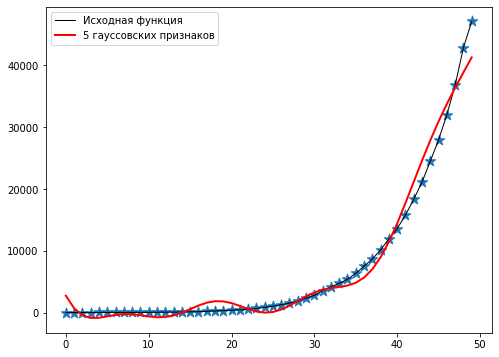

In [68]:
nums_gauss = [5]
gauss_xd, gauss_yd = X_train["day_number"].values, y_train.total_cases.values

class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=.5):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
ax.plot(gauss_xd, gauss_yd, linewidth=1, label="Исходная функция", color="black")

for num_gauss in nums_gauss:
    gauss_model = make_pipeline(GaussianFeatures(num_gauss),
                                LinearRegression())
    gauss_model.fit(gauss_xd.reshape(-1, 1), gauss_yd)
    yfit = gauss_model.predict(gauss_xd.reshape(-1, 1))
    print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
    ax.plot(gauss_xd, yfit, linewidth=2, label="%d гауссовских признак%s" % (num_gauss, "а" if num_gauss < 5 else "ов"),color='red' )

ax.legend(loc="upper left")
plt.show()

b) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [77]:
gauss_preds = gauss_model.predict(gauss_xd.reshape(-1, 1))

mu = np.array([0, 0])
sigma = 0.5 * np.array([[1, 0], [0, 1]])
# добавим столбец из 1
gauss_matrix = np.column_stack([np.ones(X_train.shape[0]), gauss_xd])
# оценим дисперсию шума
sigma_noise = mean_squared_error(gauss_yd, gauss_preds)

# апостериорное распределение параметров модели
curr_mu, curr_sigma = bayesian_update(mu, sigma, gauss_matrix, gauss_yd, sigma_noise)
print(f'Мат.ожидание: {cur_mu}\nДисперсия: {cur_sigma}')

Мат.ожидание: [1.5552186  0.20114868]
Дисперсия: [[ 1.05941127e-03 -3.21033718e-05]
 [-3.21033718e-05  1.31034528e-06]]


c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [78]:
def myplot_sample_lines(mu, sigma, gauss_matrix, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in abs(my_w):
        plt.plot(gauss_xd, gauss_model.predict(gauss_matrix.dot(w).reshape(-1, 1)), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.plot(X[:, 0], data['total_cases'][:size], c='red', lw=3);

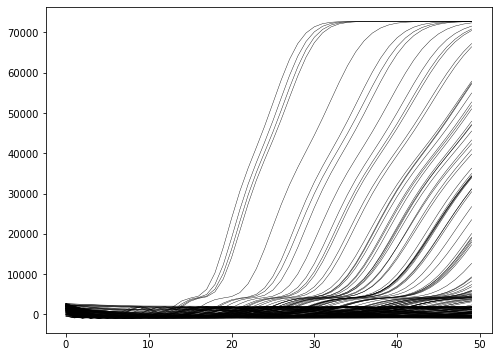

In [79]:
# Сэмплы экспонент
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
myplot_sample_lines(curr_mu, curr_sigma, gauss_matrix, 200)

In [86]:
# сгенерируем сэмплы
w = np.random.multivariate_normal(curr_mu, curr_sigma, 200)
result_data = w.dot(predict_data.T)
preds = abs(gauss_model.predict(result_data[:, 0].reshape(-1, 1)))

In [87]:
print('Реальное значение: ', int(y_train.total_cases.values[-1]))
print('Предсказанное значение: ', int(np.median(preds)))
print('Предсказанное значение (10% квантиль): ', int(np.quantile(preds, 0.1)))
print('Предсказанное значение (90% квантиль): ', int(np.quantile(preds, 0.9)))

Реальное значение:  47121
Предсказанное значение:  59149
Предсказанное значение (10% квантиль):  495
Предсказанное значение (90% квантиль):  72725
